In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import hashlib
import os
import sys
import urllib.request
import zipfile
from pathlib import Path

from tqdm import tqdm


def get_current_dir() -> Path:
    try:
        return Path(__file__).parent.absolute()
    except NameError:
        return Path(os.getcwd())


def download(dir: Path) -> Path:
    url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
    checksum = "0e33842e24a9c977be4e0107933c0723"

    # check if exists
    os.makedirs(download_dir, exist_ok=True)
    if (dir / "ml-100k").exists():
        print("already exists")
        return dir / "ml-100k"

    # download
    output_path = dir / (str(Path(url).name) + ".zip")
    response = urllib.request.urlopen(url)
    total = int(response.info().get("Content-Length").strip())
    block_size = 1024
    with open(output_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=output_path.name) as pbar:
        while True:
            buffer = response.read(block_size)
            if not buffer:
                break
            f.write(buffer)
            pbar.update(len(buffer))

    # checksum
    with open(output_path, "rb") as f:
        data = f.read()
        if hashlib.md5(data).hexdigest() != checksum:
            print("checksum is not correct")
            sys.exit(1)

    # extract
    with zipfile.ZipFile(output_path, "r") as f:
        f.extractall(dir)
    os.remove(output_path)

    return dir / "ml-100k"


download_dir = get_current_dir() / "data"
ml100k_dir = download(download_dir)

uuser = pd.read_csv(ml100k_dir / "u.user", sep="|", header=None)
uitem = pd.read_csv(ml100k_dir / "u.item", sep="|", header=None, encoding="latin1")
udata = pd.read_csv(ml100k_dir / "u.data", sep="\t", header=None)

# col headers
uuser.columns = ["user_id", "age", "gender", "occupation", "zip_code"]
uitem.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
udata.columns = ["user_id", "movie_id", "rating", "timestamp"]

# merge
merged = pd.merge(udata, uuser, on="user_id")
merged = pd.merge(merged, uitem, on="movie_id")

# parse
merged['timestamp'] = pd.to_datetime(merged['timestamp'], unit='s')
merged['release_date'] = pd.to_datetime(merged['release_date'])
merged['video_release'] = pd.to_datetime(merged['video_release_date'])

pd.set_option("display.max_columns", None)
print(merged.head())

already exists
   user_id  movie_id  rating           timestamp  age gender  occupation  \
0      196       242       3 1997-12-04 15:55:49   49      M      writer   
1      186       302       3 1998-04-04 19:22:22   39      F   executive   
2       22       377       1 1997-11-07 07:18:36   25      M      writer   
3      244        51       2 1997-11-27 05:02:03   28      M  technician   
4      166       346       1 1998-02-02 05:33:16   47      M    educator   

  zip_code                 movie_title release_date  video_release_date  \
0    55105                Kolya (1996)   1997-01-24                 NaN   
1    00000    L.A. Confidential (1997)   1997-01-01                 NaN   
2    40206         Heavyweights (1994)   1994-01-01                 NaN   
3    80525  Legends of the Fall (1994)   1994-01-01                 NaN   
4    55113         Jackie Brown (1997)   1997-01-01                 NaN   

                                            IMDb_URL  unknown  Action  \
0   

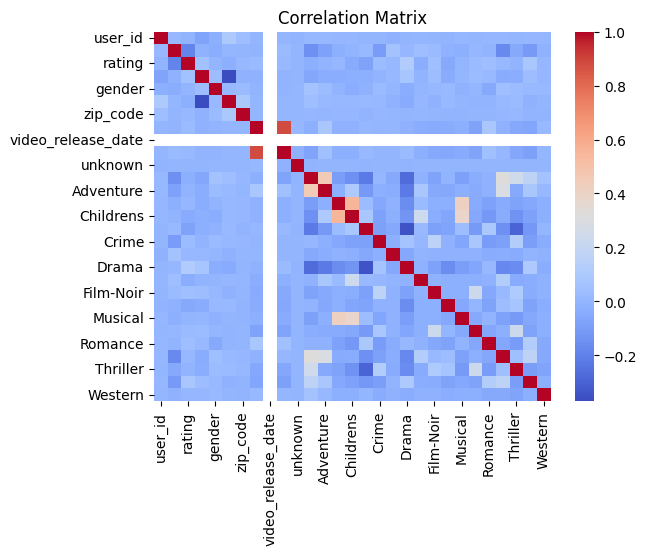

IMDb_URL     movie_title    0.877623
movie_title  IMDb_URL       0.877623
Childrens    Animation      0.555386
Animation    Childrens      0.555386
Action       Adventure      0.451525
Adventure    Action         0.451525
Musical      Animation      0.417647
Animation    Musical        0.417647
Musical      Childrens      0.381293
Childrens    Musical        0.381293
age          occupation     0.369476
occupation   age            0.369476
Comedy       Drama          0.347459
Drama        Comedy         0.347459
Action       Sci-Fi         0.323875
Sci-Fi       Action         0.323875
             Adventure      0.294811
Adventure    Sci-Fi         0.294811
Comedy       Thriller       0.290535
Thriller     Comedy         0.290535
dtype: float64

unknown       Fantasy         0.001171
Fantasy       unknown         0.001171
              user_id         0.001055
user_id       Fantasy         0.001055
IMDb_URL      Documentary     0.000956
Documentary   IMDb_URL        0.000956
unknown   

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

encoded_merged = merged.copy()
for column in encoded_merged.select_dtypes(include=['object', 'category']).columns:
    encoded_merged[column] = encoded_merged[column].astype('category').cat.codes

numeric_cols = encoded_merged.select_dtypes(include=[np.number]).columns
sns.heatmap(encoded_merged[numeric_cols].corr(), annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

corr_matrix = encoded_merged.corr().abs()
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# higheset correlation pairs
print(sorted_pairs[sorted_pairs < 1].head(20))

# lowest correlation pairs
print()
print(sorted_pairs[sorted_pairs > -1].tail(20))

In [12]:
print("# Bivariate Analysis\n")

# Numerical Variables Correlation
print("## Correlation between Numerical Variables\n")
numerical_vars = ['age', 'rating']
correlation = merged[numerical_vars].corr()
print("Correlation Matrix:")
print(correlation)
print("\n")

# Categorical Variables Contingency Tables
print("## Contingency Tables for Categorical Variables\n")

# Gender vs Occupation
print("### Gender vs Occupation")
gender_occ_table = pd.crosstab(merged['gender'], merged['occupation'], normalize='all') * 100
print("\nContingency Table (percentages):")
print(gender_occ_table.round(2))

# Gender vs Rating
print("\n### Gender vs Rating")
gender_rating_table = pd.crosstab(merged['gender'], merged['rating'], normalize='index') * 100
print("\nRating Distribution by Gender (row percentages):")
print(gender_rating_table.round(2))

# Numerical Variables by Categories
print("\n## Numerical Variables by Categories\n")

# Rating Statistics by Gender
print("### Rating Statistics by Gender")
rating_by_gender = merged.groupby('gender')['rating'].agg(['count', 'mean', 'std', 'median'])
print("\nRating statistics by gender:")
print(rating_by_gender.round(3))

# Age Statistics by Gender
print("\n### Age Statistics by Gender")
age_by_gender = merged.groupby('gender')['age'].agg(['count', 'mean', 'std', 'median'])
print("\nAge statistics by gender:")
print(age_by_gender.round(3))

# Rating Statistics by Occupation
print("\n### Rating Statistics by Occupation")
rating_by_occ = merged.groupby('occupation')['rating'].agg(['count', 'mean', 'std', 'median'])
rating_by_occ = rating_by_occ.sort_values('count', ascending=False)
print("\nRating statistics by occupation:")
print(rating_by_occ.round(3))

# Genre Preferences by Gender
print("\n### Genre Preferences by Gender")
genre_cols = ['Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
              'Thriller', 'War', 'Western']

genre_by_gender = merged.groupby('gender')[genre_cols].mean() * 100
print("\nPercentage of movies watched by gender for each genre:")
print(genre_by_gender.round(2))

# Average Rating by Age Group
print("\n### Rating Statistics by Age Group")
merged['age_group'] = pd.cut(merged['age'], bins=[0, 20, 30, 40, 50, 100], 
                            labels=['0-20', '21-30', '31-40', '41-50', '50+'])
rating_by_age = merged.groupby('age_group')['rating'].agg(['count', 'mean', 'std', 'median'])
print("\nRating statistics by age group:")
print(rating_by_age.round(3))

# Bivariate Analysis

## Correlation between Numerical Variables

Correlation Matrix:
            age   rating
age     1.00000  0.05446
rating  0.05446  1.00000


## Contingency Tables for Categorical Variables

### Gender vs Occupation

Contingency Table (percentages):
occupation  administrator  artist  doctor  educator  engineer  entertainment  \
gender                                                                         
F                    2.65    0.97    0.00      2.54      0.14           0.22   
M                    4.82    1.34    0.54      6.90      8.03           1.87   

occupation  executive  healthcare  homemaker  lawyer  librarian  marketing  \
gender                                                                       
F                0.22        2.31       0.27    0.07       2.86       0.44   
M                3.18        0.50       0.03    1.28       2.41       1.51   

occupation  none  other  programmer  retired  salesman  scientist  student  \
gender           

/var/folders/p6/sy85mkz13lsffnvz7237y4340000gn/T/ipykernel_38088/3611888802.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_by_age = merged.groupby('age_group')['rating'].agg(['count', 'mean', 'std', 'median'])


In [15]:
# 1. Contingency Tables for Categorical Variables
# Gender vs Occupation
gender_occupation = pd.crosstab(merged['gender'], merged['occupation'], normalize='index') * 100
print("\n## Gender vs Occupation Contingency Table (percentages):")
print(gender_occupation.round(2))

# Gender vs Rating
gender_rating = pd.crosstab(merged['gender'], merged['rating'], normalize='index') * 100
print("\n## Gender vs Rating Contingency Table (percentages):")
print(gender_rating.round(2))

# 2. Numerical-Categorical Analysis
# Rating statistics by gender
rating_by_gender = merged.groupby('gender')['rating'].agg(['mean', 'std', 'median', 'count'])
rating_by_gender['percentage'] = (rating_by_gender['count'] / rating_by_gender['count'].sum()) * 100
print("\n## Rating Statistics by Gender (percentages):")
print(rating_by_gender.round(2))

# Age group analysis
rating_by_age = merged.groupby('age_group')['rating'].agg(['mean', 'std', 'median', 'count'])
rating_by_age['percentage'] = (rating_by_age['count'] / rating_by_age['count'].sum()) * 100
print("\n## Rating Statistics by Age Group (percentages):")
print(rating_by_age.round(2))

# Rating statistics by occupation
rating_by_occupation = merged.groupby('occupation')['rating'].agg(['mean', 'std', 'median', 'count'])
rating_by_occupation['percentage'] = (rating_by_occupation['count'] / rating_by_occupation['count'].sum()) * 100
print("\n## Rating Statistics by Occupation (percentages):")
rating_by_occupation = rating_by_occupation.sort_values('mean', ascending=False)
print(rating_by_occupation.round(2))

# Chi-square test for gender and rating
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(gender_rating)
print("\n## Chi-square test for Gender vs Rating:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")

# Correlation between age and rating
correlation = merged['age'].corr(merged['rating'])
print("\n## Correlation between Age and Rating:")
print(f"Pearson correlation coefficient: {correlation:.4f}")


## Gender vs Occupation Contingency Table (percentages):
occupation  administrator  artist  doctor  educator  engineer  entertainment  \
gender                                                                         
F                   10.31    3.77    0.00      9.86      0.56           0.87   
M                    6.50    1.80    0.73      9.30     10.81           2.52   

occupation  executive  healthcare  homemaker  lawyer  librarian  marketing  \
gender                                                                       
F                0.86        8.96       1.05    0.27      11.11       1.72   
M                4.28        0.67       0.04    1.72       3.25       2.03   

occupation  none  other  programmer  retired  salesman  scientist  student  \
gender                                                                       
F           1.42  14.24        1.63     0.28      1.32       0.54    22.13   
M           0.72   9.42        9.94     2.07      0.70       2.58    21.90

/var/folders/p6/sy85mkz13lsffnvz7237y4340000gn/T/ipykernel_38088/3458431200.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_by_age = merged.groupby('age_group')['rating'].agg(['mean', 'std', 'median', 'count'])
